In [1]:
%pip install pandas boto3 matplotlib

Note: you may need to restart the kernel to use updated packages.


/usr/local/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)



Menu de Gráficos - Sistema de Monitoramento Inteligente das Filas nas UPAs
Data atual utilizada: 2025-04-29
1. Perfil com Febre e Baixa Oximetria
2. Verificar Pacientes com Febre ou Oximetria Grave
0. Sair
Escolha uma opção: 1
Digite o ID da UPA: 1


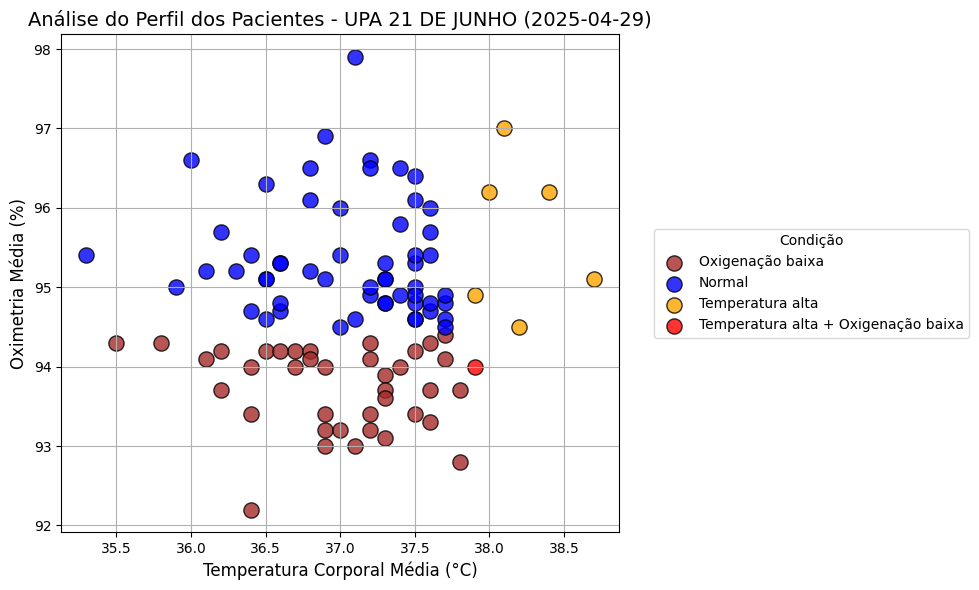


Menu de Gráficos - Sistema de Monitoramento Inteligente das Filas nas UPAs
Data atual utilizada: 2025-04-29
1. Perfil com Febre e Baixa Oximetria
2. Verificar Pacientes com Febre ou Oximetria Grave
0. Sair


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import boto3
import io
from datetime import date

# Define a data no início do código
data_atual = date(2025, 4, 29)
data_string = data_atual.strftime('%Y-%m-%d')

# Nome do bucket e arquivos
BUCKET_NAME = 'bucket-trusted-upa-connect'

# Caminhos dos arquivos CSV no S3
TEMPERATURA_FILE_KEY = 'temperatura_paciente_tratado.csv/part-00000-d07413bc-c0b6-4720-9575-13b53d3a0519-c000.csv'
OXIMETRO_FILE_KEY = 'oximetria_paciente_tratado.csv/part-00000-aad9ed77-a4db-4bf7-a8d0-5173a8586eaf-c000.csv'
PACIENTE_FILE_KEY = 'paciente.csv'
UPA_FILE_KEY = 'upa.csv'

# Cria o cliente S3
s3 = boto3.client('s3')

# Função para carregar CSVs
def carregar_csv(bucket, file_key):
    obj = s3.get_object(Bucket=bucket, Key=file_key)
    return pd.read_csv(io.BytesIO(obj['Body'].read()))

# Carregar DataFrames
df_temperatura = carregar_csv(BUCKET_NAME, TEMPERATURA_FILE_KEY)
df_oximetro = carregar_csv(BUCKET_NAME, OXIMETRO_FILE_KEY)
df_paciente = carregar_csv(BUCKET_NAME, PACIENTE_FILE_KEY)
df_upa = carregar_csv(BUCKET_NAME, UPA_FILE_KEY)

# display(df_paciente.head())
# display(df_temperatura.head())
# display(df_oximetro.head())
# display(df_upa.head())

# Renomear colunas para consistência (se necessário)
df_temperatura.rename(columns={'fk_paciente': 'id_paciente', 'media_temperatura': 'temperatura'}, inplace=True)
df_oximetro.rename(columns={'fk_paciente': 'id_paciente', 'media_oximetria': 'oximetria'}, inplace=True)

# Converter coluna de data para datetime
df_temperatura['data_hora'] = pd.to_datetime(df_temperatura['data_hora']).dt.date
df_oximetro['data_hora'] = pd.to_datetime(df_oximetro['data_hora']).dt.date

def buscar_nome_upa(fk_upa):
    try:
        nome = df_upa.loc[df_upa['id_upa'] == fk_upa, 'nome'].values
        return nome[0] if len(nome) > 0 else f"UPA {fk_upa}"
    except Exception as e:
        print("Erro ao buscar nome da UPA:", e)
        return f"UPA {fk_upa}"

def buscar_dados_paciente(fk_upa=1, data=data_string):
    try:
        # Filtra pacientes da UPA
        pacientes_upa = df_paciente[df_paciente['fk_upa'] == fk_upa][['id_paciente']]

        # Filtra temperaturas para a data e pacientes da UPA
        temp_data = df_temperatura[df_temperatura['data_hora'] == pd.to_datetime(data).date()]
        temp_upa = pd.merge(pacientes_upa, temp_data, on='id_paciente', how='inner')

        # Filtra oximetrias para a data e pacientes da UPA
        oxi_data = df_oximetro[df_oximetro['data_hora'] == pd.to_datetime(data).date()]
        oxi_upa = pd.merge(pacientes_upa, oxi_data, on='id_paciente', how='inner')

        # Merge das temperaturas e oximetrias
        df_merged = pd.merge(temp_upa[['id_paciente', 'temperatura']], oxi_upa[['id_paciente', 'oximetria']], on='id_paciente', how='inner')

        return df_merged['id_paciente'].tolist(), df_merged['temperatura'].tolist(), df_merged['oximetria'].tolist()
    except Exception as e:
        print("Erro ao buscar dados dos pacientes:", e)
        return [], [], []

def grafico_3(fk_upa=1, data=data_string):
    pacientes, temperaturas_medias, oximetrias_medias = buscar_dados_paciente(fk_upa=fk_upa, data=data)
    nome_upa = buscar_nome_upa(fk_upa)

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    legenda_usada = {}

    for paciente, t, o in zip(pacientes, temperaturas_medias, oximetrias_medias):
        if t > 39:
            cor = 'red'
            legenda = 'Febre muito alta'
        elif t < 35.3 and o < 94.5:
            cor = 'purple'
            legenda = 'Temp. baixa + Oxigenação baixa'
        elif t > 37.8 and o < 94.5:
            cor = 'red'
            legenda = 'Temperatura alta + Oxigenação baixa'
        elif t > 37.8:
            cor = 'orange'
            legenda = 'Temperatura alta'
        elif o < 94.5:
            cor = 'brown'
            legenda = 'Oxigenação baixa'
        else:
            cor = 'blue'
            legenda = 'Normal'

        if legenda not in legenda_usada:
            ax.scatter(t, o, color=cor, edgecolors='black', s=120, alpha=0.8, label=legenda)
            legenda_usada[legenda] = True
        else:
            ax.scatter(t, o, color=cor, edgecolors='black', s=120, alpha=0.8)

    ax.set_xlabel('Temperatura Corporal Média (°C)', fontsize=12)
    ax.set_ylabel('Oximetria Média (%)', fontsize=12)
    ax.set_title(f"Análise do Perfil dos Pacientes - {nome_upa} ({data})", fontsize=14)
    ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10, title="Condição")
    plt.tight_layout()
    plt.show()

def verificar_pacientes_com_febre_ou_oximetria_grave(fk_upa=1, data=data_string):
    try:
        # Filtra pacientes da UPA e seus nomes
        pacientes_upa_info = df_paciente[df_paciente['fk_upa'] == fk_upa][['id_paciente', 'nome']]

        # Busca dados de temperatura e oximetria para a UPA e data
        pacientes_temp, temperaturas_medias, oximetrias_medias = buscar_dados_paciente(fk_upa=fk_upa, data=data)

        # Cria um DataFrame temporário com os resultados
        df_resultados = pd.DataFrame({
            'id_paciente': pacientes_temp,
            'temperatura': temperaturas_medias,
            'oximetria': oximetrias_medias
        })

        # Merge com as informações dos pacientes para obter o nome
        df_merged = pd.merge(df_resultados, pacientes_upa_info, on='id_paciente', how='inner')

        for index, row in df_merged.iterrows():
            if row['temperatura'] > 37.8 or row['oximetria'] < 92:
                print(f"Paciente com febre ou oximetria grave: {row['nome']}")

    except Exception as e:
        print("Erro ao verificar pacientes:", e)

# Menu
menu = {
    "1": lambda: grafico_3(fk_upa=int(input("Digite o ID da UPA: ")), data=data_string),
    "2": lambda: verificar_pacientes_com_febre_ou_oximetria_grave(fk_upa=int(input("Digite o ID da UPA: ")), data=data_string),
}

if __name__ == "__main__":
    while True:
        print("\nMenu de Gráficos - Sistema de Monitoramento Inteligente das Filas nas UPAs")
        print(f"Data atual utilizada: {data_string}")
        print("1. Perfil com Febre e Baixa Oximetria")
        print("2. Verificar Pacientes com Febre ou Oximetria Grave")
        print("0. Sair")
        opcao = input("Escolha uma opção: ")

        if opcao == "0":
            print("Saindo...")
            break
        elif opcao in menu:
            menu[opcao]()
        else:
            print("Opção inválida. Tente novamente.")

# 